<a href="https://colab.research.google.com/github/farazabir/rokomari_recommendation/blob/main/rokomarirecomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("books1_120000.csv")

In [3]:
df.head()

,book_id,book_name,book_link,summary,author,author_des
0,1,সুশাসনের সন্ধানে(হার্ডকভার),https://www.rokomari.com/book/1,"""সুশাসনের সন্ধানে"" বইটির প্রথম ফ্ল্যাপ-এর লেখা...",আতিউর রহমান,Atiur Rahman- রহমান বাংলাদেশের বিশিষ্ট অর্থনীত...
1,2,শেষের কবিতা(হার্ডকভার),https://www.rokomari.com/book/2,‘শেষের কবিতা’ বইয়ের কিছু অংশঃঅমিত-চরিতঅমিত রায...,রবীন্দ্রনাথ ঠাকুর,বিশ্বকবি রবীন্দ্রনাথ ঠাকুর ছিলেন একাধারে ঔপন্য...
2,3,নৌকাডুবি(হার্ডকভার),https://www.rokomari.com/book/3,"""নৌকাডুবি” বইয়ের ভূমিকার থেকে নেয়া:পাঠক যে ভার...",রবীন্দ্রনাথ ঠাকুর,বিশ্বকবি রবীন্দ্রনাথ ঠাকুর ছিলেন একাধারে ঔপন্য...
3,4,গোরা(হার্ডকভার),https://www.rokomari.com/book/4,NaN,রবীন্দ্রনাথ ঠাকুর,বিশ্বকবি রবীন্দ্রনাথ ঠাকুর ছিলেন একাধারে ঔপন্য...
4,5,চোখের বালি(হার্ডকভার),https://www.rokomari.com/book/5,”চোখের বালি” বইটির সম্পর্কে কিছু কথাঃচোখের বাল...,রবীন্দ্রনাথ ঠাকুর,বিশ্বকবি রবীন্দ্রনাথ ঠাকুর ছিলেন একাধারে ঔপন্য...


In [4]:
df = df.map(lambda x: x.strip().lower() if isinstance(x, str) else x)

In [5]:
invalid_values = ["N/A", "NaN"]
df.replace(invalid_values, pd.NA, inplace=True)
df.dropna(inplace=True)

In [6]:
df['summary'] = df['summary'].fillna('')
df['author_des'] = df['author_des'].fillna('')
df['combined_text'] = df['summary'] + " " + df['author_des']

In [ ]:
with open("banglastopword.txt", "r", encoding="utf-8") as f:
    banglast = list(f.read().splitlines())

In [9]:
tfidf_vectorizer = TfidfVectorizer(stop_words=banglals,max_features=5000)

In [10]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_text'])
print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (13338, 5000)


In [12]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print("Similarity matrix shape:", cosine_sim.shape)

Similarity matrix shape: (13338, 13338)


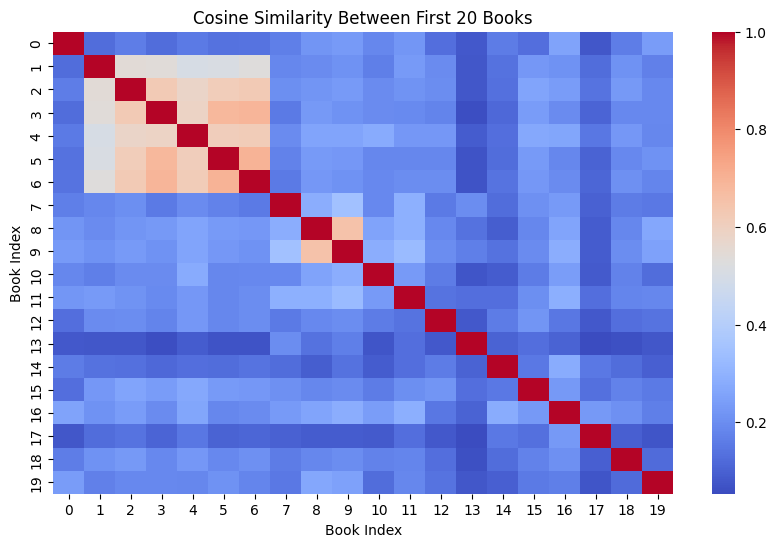

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(cosine_sim[:20, :20], cmap='coolwarm', annot=False)
plt.title("Cosine Similarity Between First 20 Books")
plt.xlabel("Book Index")
plt.ylabel("Book Index")
plt.show()


In [14]:
conn = sqlite3.connect("book.db")
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS books (
    book_id INTEGER PRIMARY KEY,
    book_name TEXT,
    book_link TEXT,
    author TEXT
)
''')


for _, row in df.iterrows():
    cursor.execute("INSERT OR IGNORE INTO books VALUES (?, ?, ?, ?)",
                   (int(row['book_id']), row['book_name'], row['book_link'], row['author']))

cursor.execute('''
CREATE TABLE IF NOT EXISTS recommendations (
    book_id INTEGER,
    similar_book_id INTEGER,
    similarity_score REAL
)
''')

N = 10
for idx, book_id in enumerate(df['book_id']):
    similar_indices = np.argsort(-cosine_sim[idx])[:N+1]
    for sim_idx in similar_indices[1:]:
        cursor.execute("INSERT INTO recommendations VALUES (?, ?, ?)",
                       (int(book_id), int(df['book_id'].iloc[sim_idx]), float(cosine_sim[idx, sim_idx])))

conn.commit()
conn.close()

print("Database setup complete!")

Database setup complete!


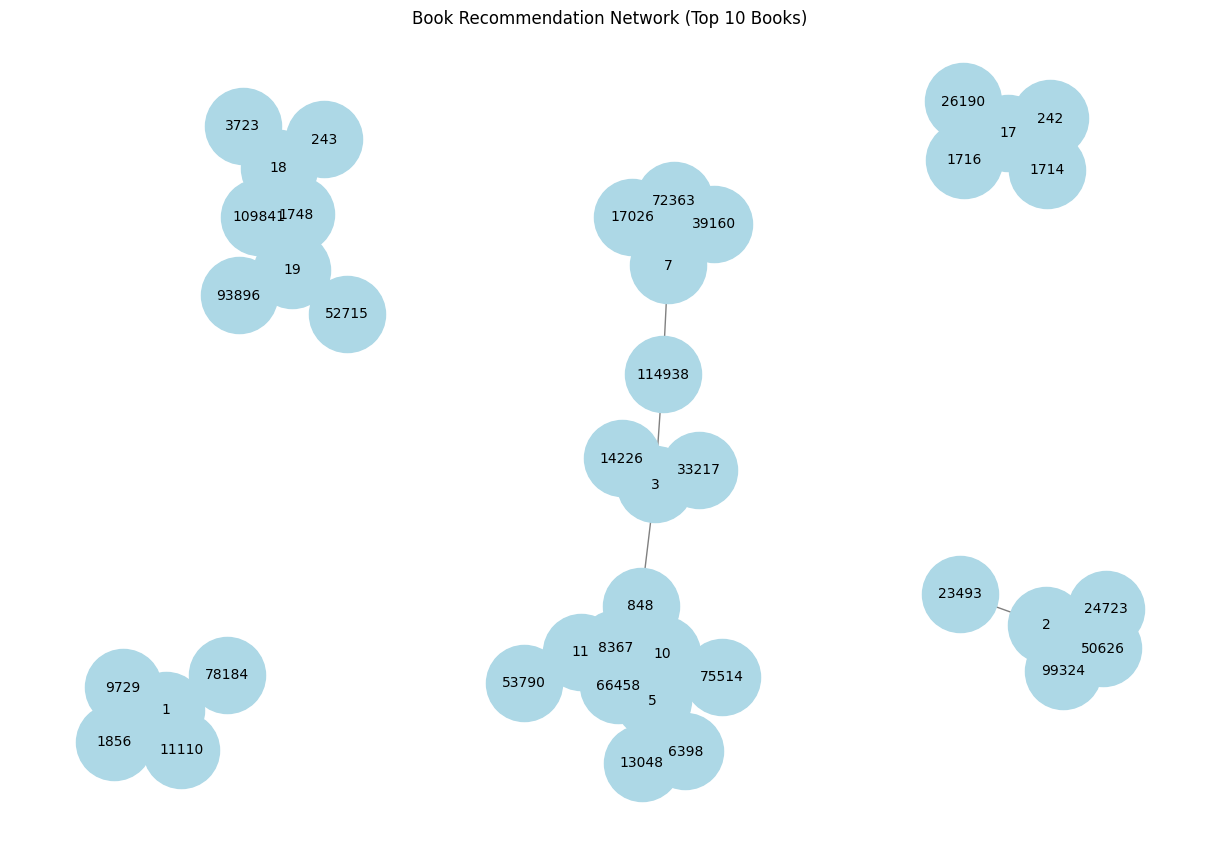

In [15]:
import networkx as nx

G = nx.Graph()
for idx, book_id in enumerate(df['book_id'][:10]):
    G.add_node(book_id, label=df['book_name'].iloc[idx])

    similar_indices = np.argsort(-cosine_sim[idx])[:5]
    for sim_idx in similar_indices[1:]:
        G.add_edge(book_id, df['book_id'].iloc[sim_idx], weight=cosine_sim[idx, sim_idx])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10)
plt.title("Book Recommendation Network (Top 10 Books)")
plt.show()


In [16]:
def get_recommendations(book_id):
    conn = sqlite3.connect("book_recommendations.db")
    cursor = conn.cursor()


    query = '''
    SELECT b.book_name, b.author,b.book_link
    FROM recommendations r
    JOIN books b ON r.similar_book_id = b.book_id
    WHERE r.book_id = ?
    ORDER BY r.similarity_score DESC
    LIMIT 10
    '''
    cursor.execute(query, (int(book_id),))

    results = cursor.fetchall()
    conn.close()

    return results

In [17]:
recommended_books = get_recommendations(1)
print(recommended_books)

[('মানবিক ব্যাংকিং(হার্ডকভার)', 'আতিউর রহমান', 'https://www.rokomari.com/book/78184'), ('রবীন্দ্রনাথ : কৃষিভাবনা(হার্ডকভার)', 'আতিউর রহমান', 'https://www.rokomari.com/book/11110'), ('রবীন্দ্রভাবনায় সমাজ, সংস্কৃতি ও অর্থনীতি(হার্ডকভার)', 'আতিউর রহমান', 'https://www.rokomari.com/book/9729'), ('মুক্তিযুদ্ধের মানুষ মুক্তিযুদ্ধের স্বপ্ন(হার্ডকভার)', 'আতিউর রহমান', 'https://www.rokomari.com/book/1856'), ('মুক্তিযুদ্ধ জনযুদ্ধ আর্থ-সামাজিক পরিপ্রেক্ষিত(হার্ডকভার)', 'আতিউর রহমান', 'https://www.rokomari.com/book/1855'), ('উন্নয়ন আলাপ : অর্থনীতি, পরিবেশ ও উন্নয়ন বিতর্ক', 'আতিউর রহমান', 'https://www.rokomari.com/book/11386'), ('রবীন্দ্র চিন্তায় দারিদ্র ও প্রগতি(হার্ডকভার)', 'আতিউর রহমান', 'https://www.rokomari.com/book/435'), ('জনগণের বাজেট : অংশগ্রহণমূলক পরিপ্রেক্ষিত', 'আতিউর রহমান', 'https://www.rokomari.com/book/11391'), ('আগামী দিনের বাংলাদেশ : একুশ শতকের উন্নয়ন ভাবনা', 'আতিউর রহমান', 'https://www.rokomari.com/book/11389'), ('ভাষা-আন্দোলনের আর্থ-সামাজিক পটভূমি', 'আতিউর রহমান', 'https://www.rok